# TQQQ MA200 Backtesting Strategy

## Strategy Rules:
- **BUY TQQQ** when: QQQ > MA200 × 1.04 AND QQQ daily loss >= 1%
- **SELL** when: QQQ < MA200 × 0.97

This notebook walks through each step of the backtest.

## Step 1: Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)
%matplotlib inline
plt.style.use('seaborn-v0_8-whitegrid')

## Step 2: Define Parameters

Adjust these parameters to customize your backtest:

In [ ]:
# Backtest parameters
START_DATE = "2015-01-01"
END_DATE = "2025-01-17"
INITIAL_CAPITAL = 100000

# Strategy parameters
MA_PERIOD = 200
BUY_THRESHOLD = 1.04      # QQQ > MA200 * 1.04
SELL_THRESHOLD = 0.97     # QQQ < MA200 * 0.97
DAILY_LOSS_THRESHOLD = -0.01  # QQQ daily loss >= 1%

print(f"Backtest Period: {START_DATE} to {END_DATE}")
print(f"Initial Capital: ${INITIAL_CAPITAL:,}")
print(f"\nStrategy Rules:")
print(f"  BUY when: QQQ > MA{MA_PERIOD} × {BUY_THRESHOLD} AND daily loss >= {abs(DAILY_LOSS_THRESHOLD)*100}%")
print(f"  SELL when: QQQ < MA{MA_PERIOD} × {SELL_THRESHOLD}")

## Step 3: Fetch Historical Data

In [ ]:
# Fetch extra data for MA200 calculation
extended_start = pd.to_datetime(START_DATE) - pd.Timedelta(days=300)

print(f"Fetching QQQ data from {extended_start.date()}...")
qqq_data = yf.download('QQQ', start=extended_start, end=END_DATE, progress=False)

print(f"Fetching TQQQ data from {extended_start.date()}...")
tqqq_data = yf.download('TQQQ', start=extended_start, end=END_DATE, progress=False)

# Handle multi-level columns from yfinance
if isinstance(qqq_data.columns, pd.MultiIndex):
    qqq_data.columns = qqq_data.columns.get_level_values(0)
if isinstance(tqqq_data.columns, pd.MultiIndex):
    tqqq_data.columns = tqqq_data.columns.get_level_values(0)

print(f"\nQQQ data: {qqq_data.shape[0]} rows")
print(f"TQQQ data: {tqqq_data.shape[0]} rows")

In [4]:
# Preview the data
print("QQQ Data (last 5 rows):")
qqq_data.tail()

QQQ Data (last 5 rows):


Price,Close,High,Low,Open,Volume
Date,,,,,
2025-01-10,504.63,509.00,501.38,508.90,40532500
2025-01-13,503.01,503.47,497.18,498.67,31694200
2025-01-14,502.53,507.59,499.06,506.17,33737200
2025-01-15,514.09,515.24,508.88,510.44,34957600
2025-01-16,510.49,516.44,510.36,516.36,28229000


In [ ]:
print("TQQQ Data (last 5 rows):")
tqqq_data.tail()

## Step 4: Calculate Technical Indicators

In [6]:
# Calculate 200-day moving average
qqq_data['MA200'] = qqq_data['Close'].rolling(window=MA_PERIOD).mean()

# Calculate daily returns
qqq_data['Daily_Return'] = qqq_data['Close'].pct_change()

# Calculate buy/sell threshold levels
qqq_data['Buy_Level'] = qqq_data['MA200'] * BUY_THRESHOLD
qqq_data['Sell_Level'] = qqq_data['MA200'] * SELL_THRESHOLD

print("Indicators calculated!")
qqq_data[['Close', 'MA200', 'Daily_Return', 'Buy_Level', 'Sell_Level']].tail(10)

Indicators calculated!


Price,Close,MA200,Daily_Return,Buy_Level,Sell_Level
Date,,,,,
2025-01-02,507.66,471.49,-0.00,490.35,457.35
2025-01-03,515.96,471.90,0.02,490.78,457.75
2025-01-06,521.89,472.31,0.01,491.21,458.15
2025-01-07,512.58,472.67,-0.02,491.58,458.49
2025-01-08,512.67,473.02,0.00,491.94,458.83
2025-01-10,504.63,473.34,-0.02,492.28,459.14
2025-01-13,503.01,473.66,-0.00,492.61,459.45
2025-01-14,502.53,473.97,-0.00,492.93,459.75
2025-01-15,514.09,474.34,0.02,493.32,460.11


## Step 5: Visualize QQQ with MA200

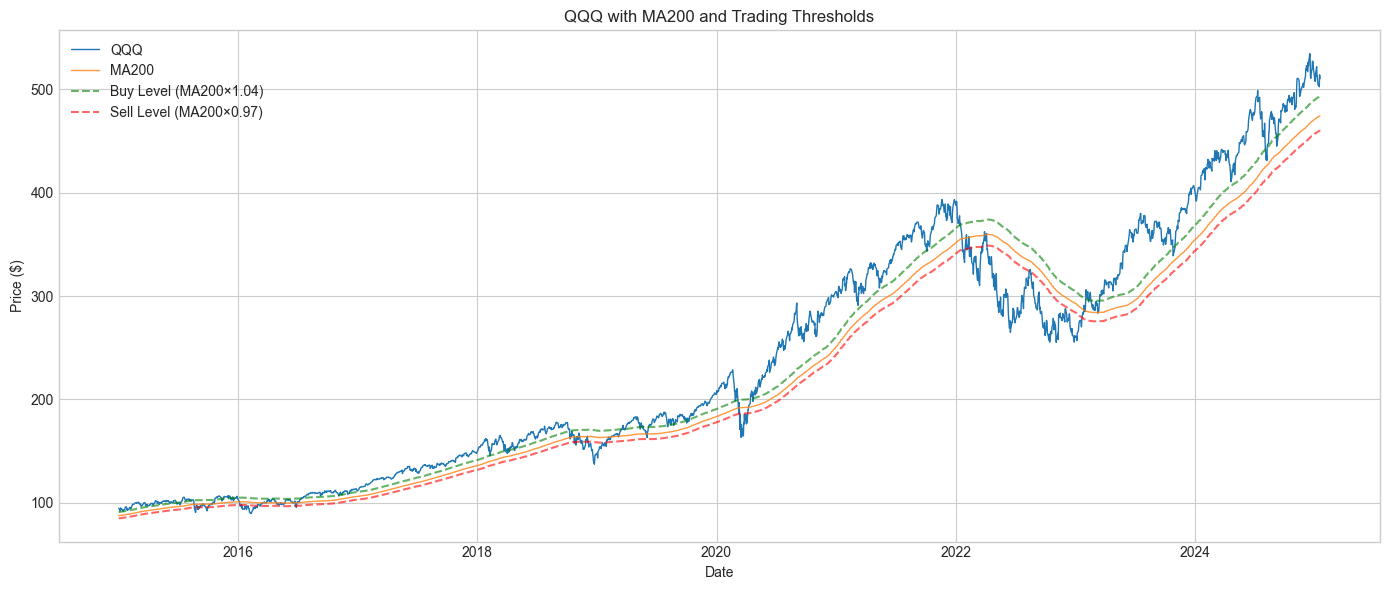

In [7]:
# Filter to backtest period for visualization
qqq_plot = qqq_data[qqq_data.index >= START_DATE]

plt.figure(figsize=(14, 6))
plt.plot(qqq_plot.index, qqq_plot['Close'], label='QQQ', linewidth=1)
plt.plot(qqq_plot.index, qqq_plot['MA200'], label='MA200', linewidth=1, alpha=0.8)
plt.plot(qqq_plot.index, qqq_plot['Buy_Level'], label=f'Buy Level (MA200×{BUY_THRESHOLD})', 
         linestyle='--', alpha=0.6, color='green')
plt.plot(qqq_plot.index, qqq_plot['Sell_Level'], label=f'Sell Level (MA200×{SELL_THRESHOLD})', 
         linestyle='--', alpha=0.6, color='red')

plt.title('QQQ with MA200 and Trading Thresholds')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.tight_layout()
plt.show()

## Step 6: Generate Trading Signals

In [ ]:
# Filter to backtest period
qqq_data = qqq_data[qqq_data.index >= START_DATE].copy()
tqqq_data = tqqq_data[tqqq_data.index >= START_DATE].copy()

# Align data on common dates
common_dates = qqq_data.index.intersection(tqqq_data.index)
qqq_data = qqq_data.loc[common_dates]
tqqq_data = tqqq_data.loc[common_dates]

print(f"Backtest period: {common_dates[0].date()} to {common_dates[-1].date()}")
print(f"Trading days: {len(common_dates)}")

In [ ]:
# Create signals DataFrame
signals = pd.DataFrame(index=qqq_data.index)
signals['QQQ_Close'] = qqq_data['Close']
signals['TQQQ_Close'] = tqqq_data['Close']
signals['MA200'] = qqq_data['MA200']
signals['Daily_Return'] = qqq_data['Daily_Return']
signals['Buy_Level'] = qqq_data['Buy_Level']
signals['Sell_Level'] = qqq_data['Sell_Level']

# Buy condition: QQQ > MA200 * 1.04 AND daily loss >= 1%
signals['Buy_Condition'] = (
    (signals['QQQ_Close'] > signals['Buy_Level']) &
    (signals['Daily_Return'] <= DAILY_LOSS_THRESHOLD)
)

# Sell condition: QQQ < MA200 * 0.97
signals['Sell_Condition'] = signals['QQQ_Close'] < signals['Sell_Level']

print("Days meeting BUY condition:", signals['Buy_Condition'].sum())
print("Days meeting SELL condition:", signals['Sell_Condition'].sum())

In [10]:
# Generate position signals (1 = long TQQQ, 0 = cash)
signals['Signal'] = 0
position = 0

for i in range(len(signals)):
    if position == 0 and signals['Buy_Condition'].iloc[i]:
        position = 1
        signals.iloc[i, signals.columns.get_loc('Signal')] = 1
    elif position == 1 and signals['Sell_Condition'].iloc[i]:
        position = 0
        signals.iloc[i, signals.columns.get_loc('Signal')] = 0
    else:
        signals.iloc[i, signals.columns.get_loc('Signal')] = position

# Track position changes
signals['Position_Change'] = signals['Signal'].diff().fillna(0)

print("Signal generation complete!")

Signal generation complete!


## Step 7: View Trade Log

In [ ]:
# Extract trades
trades = signals[signals['Position_Change'] != 0].copy()
trades['Action'] = trades['Position_Change'].apply(lambda x: 'BUY' if x == 1 else 'SELL')
trades['QQQ_Daily_Return'] = trades['Daily_Return'].apply(lambda x: f"{x*100:.2f}%")

trade_log = trades[['Action', 'QQQ_Close', 'TQQQ_Close', 'MA200', 'QQQ_Daily_Return']].copy()
trade_log.columns = ['Action', 'QQQ Price', 'TQQQ Price', 'MA200', 'QQQ Daily Return']

print(f"Total Trades: {len(trades[trades['Action'] == 'BUY'])} round trips")
print("\nTrade Log:")
trade_log

## Step 8: Run Backtest Simulation

In [12]:
# Create portfolio DataFrame
portfolio = pd.DataFrame(index=signals.index)

# Calculate TQQQ daily returns
tqqq_returns = tqqq_data['Close'].pct_change().fillna(0)

# Use shifted signal to avoid look-ahead bias
portfolio['Position'] = signals['Signal'].shift(1).fillna(0)
portfolio['TQQQ_Return'] = tqqq_returns
portfolio['Strategy_Return'] = portfolio['Position'] * portfolio['TQQQ_Return']

# Calculate cumulative returns
portfolio['Cumulative_TQQQ'] = (1 + portfolio['TQQQ_Return']).cumprod()
portfolio['Cumulative_Strategy'] = (1 + portfolio['Strategy_Return']).cumprod()

# Calculate portfolio values
portfolio['TQQQ_Value'] = INITIAL_CAPITAL * portfolio['Cumulative_TQQQ']
portfolio['Strategy_Value'] = INITIAL_CAPITAL * portfolio['Cumulative_Strategy']

print("Backtest simulation complete!")
portfolio[['Position', 'TQQQ_Return', 'Strategy_Return', 'Strategy_Value', 'TQQQ_Value']].tail(10)

Backtest simulation complete!


,Position,TQQQ_Return,Strategy_Return,Strategy_Value,TQQQ_Value
Date,,,,,
2025-01-02,1.00,-0.01,-0.01,1659710.32,2028481.30
2025-01-03,1.00,0.05,0.05,1739286.91,2125739.01
2025-01-06,1.00,0.03,0.03,1798599.95,2198230.82
2025-01-07,1.00,-0.05,-0.05,1701715.21,2079819.26
2025-01-08,1.00,0.00,0.00,1702981.58,2081367.00
2025-01-10,1.00,-0.05,-0.05,1621716.11,1982045.17
2025-01-13,1.00,-0.01,-0.01,1604829.98,1961407.10
2025-01-14,1.00,-0.00,-0.00,1599130.91,1954441.75
2025-01-15,1.00,0.07,0.07,1707202.87,2086526.22


## Step 9: Calculate Performance Metrics

In [13]:
def calculate_metrics(portfolio, initial_capital):
    """Calculate performance metrics."""
    strategy_returns = portfolio['Strategy_Return']
    tqqq_returns = portfolio['TQQQ_Return']
    
    # Total return
    total_strategy_return = (portfolio['Strategy_Value'].iloc[-1] / initial_capital - 1) * 100
    total_tqqq_return = (portfolio['TQQQ_Value'].iloc[-1] / initial_capital - 1) * 100
    
    # Annualized return
    trading_days = len(portfolio)
    years = trading_days / 252
    ann_strategy = ((1 + total_strategy_return / 100) ** (1 / years) - 1) * 100
    ann_tqqq = ((1 + total_tqqq_return / 100) ** (1 / years) - 1) * 100
    
    # Volatility (annualized)
    strategy_vol = strategy_returns.std() * np.sqrt(252) * 100
    tqqq_vol = tqqq_returns.std() * np.sqrt(252) * 100
    
    # Sharpe ratio
    sharpe_strategy = ann_strategy / strategy_vol if strategy_vol > 0 else 0
    sharpe_tqqq = ann_tqqq / tqqq_vol if tqqq_vol > 0 else 0
    
    # Maximum drawdown
    strategy_cummax = portfolio['Strategy_Value'].cummax()
    strategy_dd = (portfolio['Strategy_Value'] - strategy_cummax) / strategy_cummax
    max_dd_strategy = strategy_dd.min() * 100
    
    tqqq_cummax = portfolio['TQQQ_Value'].cummax()
    tqqq_dd = (portfolio['TQQQ_Value'] - tqqq_cummax) / tqqq_cummax
    max_dd_tqqq = tqqq_dd.min() * 100
    
    # Time in market
    time_in_market = portfolio['Position'].mean() * 100
    
    return {
        'Total Return (%)': [round(total_strategy_return, 2), round(total_tqqq_return, 2)],
        'Annualized Return (%)': [round(ann_strategy, 2), round(ann_tqqq, 2)],
        'Volatility (%)': [round(strategy_vol, 2), round(tqqq_vol, 2)],
        'Sharpe Ratio': [round(sharpe_strategy, 2), round(sharpe_tqqq, 2)],
        'Max Drawdown (%)': [round(max_dd_strategy, 2), round(max_dd_tqqq, 2)],
        'Final Value ($)': [round(portfolio['Strategy_Value'].iloc[-1], 2), 
                           round(portfolio['TQQQ_Value'].iloc[-1], 2)],
    }, time_in_market

metrics, time_in_market = calculate_metrics(portfolio, INITIAL_CAPITAL)

# Display as DataFrame
metrics_df = pd.DataFrame(metrics, index=['Strategy', 'Buy & Hold TQQQ']).T
print("\n" + "="*50)
print("PERFORMANCE COMPARISON")
print("="*50)
print(metrics_df)
print(f"\nTime in Market: {time_in_market:.2f}%")
print(f"Number of Trades: {len(trades[trades['Action'] == 'BUY'])}")


PERFORMANCE COMPARISON
                        Strategy  Buy & Hold TQQQ
Total Return (%)         1572.38          1943.96
Annualized Return (%)      32.45            35.13
Volatility (%)             47.65            64.52
Sharpe Ratio                0.68             0.54
Max Drawdown (%)          -64.76           -81.66
Final Value ($)       1672375.16       2043960.14

Time in Market: 74.58%
Number of Trades: 6


## Step 10: Visualize Results

In [ ]:
fig, axes = plt.subplots(3, 1, figsize=(14, 12))

# Plot 1: Portfolio value comparison
ax1 = axes[0]
ax1.plot(portfolio.index, portfolio['Strategy_Value'], label='Strategy', linewidth=1.5, color='blue')
ax1.plot(portfolio.index, portfolio['TQQQ_Value'], label='Buy & Hold TQQQ', linewidth=1.5, color='orange', alpha=0.7)
ax1.set_title('Portfolio Value: Strategy vs Buy & Hold TQQQ', fontsize=12)
ax1.set_ylabel('Portfolio Value ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: QQQ with signals
ax2 = axes[1]
ax2.plot(signals.index, signals['QQQ_Close'], label='QQQ', linewidth=1, color='black')
ax2.plot(signals.index, signals['MA200'], label='MA200', linewidth=1, color='blue', alpha=0.7)
ax2.plot(signals.index, signals['Buy_Level'], label=f'Buy Level (MA200×{BUY_THRESHOLD})', 
         linewidth=1, linestyle='--', color='green', alpha=0.5)
ax2.plot(signals.index, signals['Sell_Level'], label=f'Sell Level (MA200×{SELL_THRESHOLD})', 
         linewidth=1, linestyle='--', color='red', alpha=0.5)

# Mark buy/sell points
buys = signals[signals['Position_Change'] == 1]
sells = signals[signals['Position_Change'] == -1]
ax2.scatter(buys.index, buys['QQQ_Close'], marker='^', color='green', s=100, label='Buy', zorder=5)
ax2.scatter(sells.index, sells['QQQ_Close'], marker='v', color='red', s=100, label='Sell', zorder=5)

ax2.set_title('QQQ with MA200 and Trading Signals', fontsize=12)
ax2.set_ylabel('QQQ Price ($)')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

# Plot 3: Position over time
ax3 = axes[2]
ax3.fill_between(portfolio.index, portfolio['Position'], step='post', alpha=0.5, color='blue')
ax3.set_title('Position Over Time (1 = Long TQQQ, 0 = Cash)', fontsize=12)
ax3.set_ylabel('Position')
ax3.set_xlabel('Date')
ax3.set_ylim(-0.1, 1.1)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 11: Drawdown Analysis

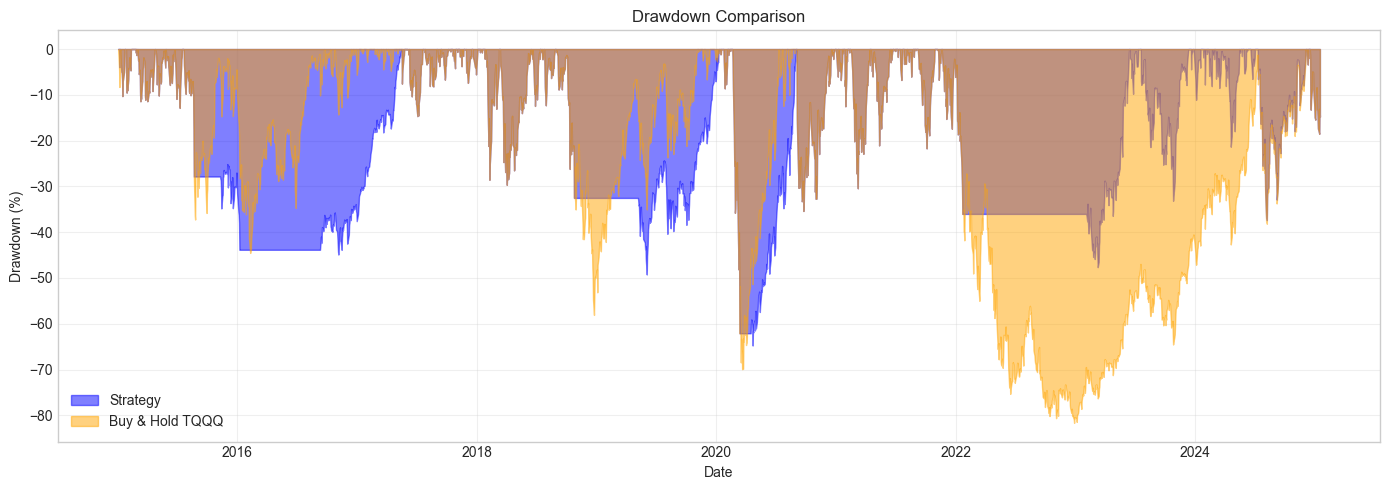

Strategy Max Drawdown: -64.76%
Buy & Hold Max Drawdown: -81.66%


In [15]:
# Calculate drawdowns
portfolio['Strategy_Drawdown'] = (portfolio['Strategy_Value'] / portfolio['Strategy_Value'].cummax() - 1) * 100
portfolio['TQQQ_Drawdown'] = (portfolio['TQQQ_Value'] / portfolio['TQQQ_Value'].cummax() - 1) * 100

plt.figure(figsize=(14, 5))
plt.fill_between(portfolio.index, portfolio['Strategy_Drawdown'], 0, alpha=0.5, label='Strategy', color='blue')
plt.fill_between(portfolio.index, portfolio['TQQQ_Drawdown'], 0, alpha=0.5, label='Buy & Hold TQQQ', color='orange')
plt.title('Drawdown Comparison')
plt.ylabel('Drawdown (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Strategy Max Drawdown: {portfolio['Strategy_Drawdown'].min():.2f}%")
print(f"Buy & Hold Max Drawdown: {portfolio['TQQQ_Drawdown'].min():.2f}%")

## Step 12: Export Results (Optional)

In [16]:
# Uncomment to export results

# Export trade log
# trade_log.to_csv('trade_log.csv')
# print("Trade log exported to trade_log.csv")

# Export portfolio data
# portfolio.to_csv('portfolio_history.csv')
# print("Portfolio history exported to portfolio_history.csv")

# Export signals
# signals.to_csv('signals.csv')
# print("Signals exported to signals.csv")

print("Uncomment the lines above to export data to CSV files.")

Uncomment the lines above to export data to CSV files.


---
## Experiment Ideas

Try modifying the parameters in **Step 2** to see how they affect performance:

1. **Change MA period**: Try MA100 or MA50 instead of MA200
2. **Adjust thresholds**: Try BUY_THRESHOLD = 1.05 or SELL_THRESHOLD = 0.95
3. **Change daily loss requirement**: Try -0.02 (2% loss) or -0.005 (0.5% loss)
4. **Different time periods**: Focus on specific market conditions (bull/bear markets)
5. **Add transaction costs**: Subtract 0.1% per trade from returns

In [ ]:
# Fetch VIX data for sentiment analysis
print("Fetching VIX data for sentiment analysis...")
extended_start = pd.to_datetime(START_DATE) - pd.Timedelta(days=300)
vix_data = yf.download('^VIX', start=extended_start, end=END_DATE, progress=False)

if isinstance(vix_data.columns, pd.MultiIndex):
    vix_data.columns = vix_data.columns.get_level_values(0)

vix_data = vix_data[vix_data.index >= START_DATE].copy()
vix_data = vix_data.loc[vix_data.index.intersection(signals.index)]

# Add VIX to signals for analysis
signals['VIX'] = vix_data['Close']

print(f"VIX data: {len(vix_data)} rows")
print(f"VIX range: {vix_data['Close'].min():.1f} - {vix_data['Close'].max():.1f}")
print(f"VIX mean: {vix_data['Close'].mean():.1f}")

In [ ]:
# VIX Threshold Optimization
def run_vix_backtest(vix_threshold, signals_df, tqqq_returns, initial_capital, years):
    """Run backtest with given VIX threshold. If 0, no VIX filter."""
    test_signals = signals_df.copy()
    
    if vix_threshold > 0:
        test_signals['Buy_Condition'] = (
            (test_signals['QQQ_Close'] > test_signals['Buy_Level']) &
            (test_signals['Daily_Return'] <= DAILY_LOSS_THRESHOLD) &
            (test_signals['VIX'] > vix_threshold)
        )
    else:
        test_signals['Buy_Condition'] = (
            (test_signals['QQQ_Close'] > test_signals['Buy_Level']) &
            (test_signals['Daily_Return'] <= DAILY_LOSS_THRESHOLD)
        )
    
    test_signals['Sell_Condition'] = test_signals['QQQ_Close'] < test_signals['Sell_Level']
    
    # Generate signals
    test_signals['Signal'] = 0
    position = 0
    for i in range(len(test_signals)):
        if position == 0 and test_signals['Buy_Condition'].iloc[i]:
            position = 1
            test_signals.iloc[i, test_signals.columns.get_loc('Signal')] = 1
        elif position == 1 and test_signals['Sell_Condition'].iloc[i]:
            position = 0
        else:
            test_signals.iloc[i, test_signals.columns.get_loc('Signal')] = position
    
    # Calculate returns
    port = pd.DataFrame(index=test_signals.index)
    port['Position'] = test_signals['Signal'].shift(1).fillna(0)
    port['Strategy_Return'] = port['Position'] * tqqq_returns
    port['Strategy_Value'] = initial_capital * (1 + port['Strategy_Return']).cumprod()
    
    total_return = (port['Strategy_Value'].iloc[-1] / initial_capital - 1) * 100
    ann_return = ((1 + total_return / 100) ** (1 / years) - 1) * 100
    volatility = port['Strategy_Return'].std() * np.sqrt(252) * 100
    sharpe = ann_return / volatility if volatility > 0 else 0
    max_dd = ((port['Strategy_Value'] / port['Strategy_Value'].cummax() - 1) * 100).min()
    num_trades = (test_signals['Signal'].diff().fillna(0) == 1).sum()
    
    return {
        'VIX Threshold': 'None' if vix_threshold == 0 else f'> {vix_threshold}',
        'Total Return %': round(total_return, 2),
        'Ann Return %': round(ann_return, 2),
        'Sharpe': round(sharpe, 2),
        'Max DD %': round(max_dd, 2),
        'Final Value': round(port['Strategy_Value'].iloc[-1], 0),
        'Trades': num_trades
    }

# Test different VIX thresholds
tqqq_returns_series = tqqq_data['Close'].pct_change().fillna(0)
years = len(signals) / 252
vix_thresholds = [0, 12, 14, 16, 18, 20, 22, 25, 28, 30]

results = [run_vix_backtest(v, signals, tqqq_returns_series, INITIAL_CAPITAL, years) for v in vix_thresholds]
results_df = pd.DataFrame(results)

print("="*80)
print("VIX THRESHOLD OPTIMIZATION RESULTS")
print("="*80)
print("(VIX = None means original strategy without VIX filter)\n")
print(results_df.to_string(index=False))

# Find best
best_return = results_df.loc[results_df['Total Return %'].idxmax()]
best_sharpe = results_df.loc[results_df['Sharpe'].idxmax()]
print(f"\nBest Total Return: {best_return['VIX Threshold']} → {best_return['Total Return %']}%")
print(f"Best Sharpe Ratio: {best_sharpe['VIX Threshold']} → {best_sharpe['Sharpe']}")

In [ ]:
# Analyze VIX on buy condition days
buy_condition_days = signals[signals['Buy_Condition'] == True]

print("="*60)
print("VIX ANALYSIS ON BUY CONDITION DAYS")
print("="*60)
print(f"Total days meeting buy condition: {len(buy_condition_days)}")
print(f"VIX range on buy days: {buy_condition_days['VIX'].min():.1f} - {buy_condition_days['VIX'].max():.1f}")
print(f"VIX mean on buy days: {buy_condition_days['VIX'].mean():.1f}")
print(f"VIX median on buy days: {buy_condition_days['VIX'].median():.1f}")

# VIX on actual trade entry days
trade_entries = signals[signals['Position_Change'] == 1]
print(f"\nActual trade entries: {len(trade_entries)}")
print(f"VIX on trade entry days:")
for date, row in trade_entries.iterrows():
    print(f"  {date.date()}: VIX = {row['VIX']:.1f}, QQQ drop = {row['Daily_Return']*100:.2f}%")

print(f"\nKey Insight: The lowest VIX on any actual trade entry was {trade_entries['VIX'].min():.1f}")
print(f"This explains why VIX thresholds <= 16 produce identical results to no filter.")

In [ ]:
# Visualize VIX with trade signals
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: VIX over time with trade markers
ax1 = axes[0]
ax1.plot(signals.index, signals['VIX'], label='VIX', linewidth=1, color='purple', alpha=0.7)
ax1.axhline(y=20, color='orange', linestyle='--', label='VIX = 20', alpha=0.5)
ax1.axhline(y=25, color='red', linestyle='--', label='VIX = 25', alpha=0.5)

# Mark trade entries
trade_entries = signals[signals['Position_Change'] == 1]
trade_exits = signals[signals['Position_Change'] == -1]
ax1.scatter(trade_entries.index, trade_entries['VIX'], marker='^', color='green', s=150, label='Buy', zorder=5)
ax1.scatter(trade_exits.index, trade_exits['VIX'], marker='v', color='red', s=150, label='Sell', zorder=5)

ax1.set_title('VIX (Fear Index) with Trade Signals', fontsize=12)
ax1.set_ylabel('VIX')
ax1.legend(loc='upper right')
ax1.grid(True, alpha=0.3)

# Plot 2: VIX distribution on buy condition days vs all days
ax2 = axes[1]
buy_condition_days = signals[signals['Buy_Condition'] == True]
ax2.hist(signals['VIX'].dropna(), bins=50, alpha=0.5, label='All Days', color='gray')
ax2.hist(buy_condition_days['VIX'].dropna(), bins=30, alpha=0.7, label='Buy Condition Days', color='green')
ax2.axvline(x=buy_condition_days['VIX'].mean(), color='green', linestyle='--', linewidth=2, label=f'Mean on Buy Days ({buy_condition_days["VIX"].mean():.1f})')
ax2.axvline(x=signals['VIX'].mean(), color='gray', linestyle='--', linewidth=2, label=f'Overall Mean ({signals["VIX"].mean():.1f})')

ax2.set_title('VIX Distribution: All Days vs Buy Condition Days', fontsize=12)
ax2.set_xlabel('VIX')
ax2.set_ylabel('Frequency')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nConclusion: Buy condition days naturally have higher VIX (mean 20.8 vs 18.5 overall).")
print("The 1% daily drop requirement already filters for elevated fear conditions.")

### Sentiment Analysis Summary

| VIX Threshold | Total Return | Sharpe | Trades | Verdict |
|---------------|-------------|--------|--------|---------|
| None (Original) | 1,572% | 0.68 | 6 | **Best** |
| > 16 | 1,572% | 0.68 | 6 | Same as original |
| > 18 | 586% | 0.46 | 6 | Worse |
| > 20 | 893% | 0.58 | 5 | Worse |
| > 22 | 929% | 0.60 | 5 | Worse |
| > 25+ | < 112% | < 0.23 | 3-4 | Much worse |

**Key Findings:**
1. VIX thresholds ≤ 16 have no effect (all actual trades already had VIX > 16)
2. VIX > 18 significantly hurts returns without improving risk metrics
3. The original strategy's 1% daily drop requirement naturally selects high-VIX days
4. **Recommendation: Do not add VIX filter to this strategy**